# Tutorial de Redes Neuronales Convolucionales para clasificación de imágenes

En este tutorial, aprenderemos cómo utilizar modelos de Redes Neuronales Convolucionales (CNNs) para la clasificación de imágenes utilizando PyTorch. Cubriremos los componentes básicos de una CNN, cómo construir una red y cómo utilizar técnicas para reducir el sobreajuste. Por último, también pondremos a prueba el uso de modelos pre-entrenados de arquitecturas avanzadas de CNNs como lo es ResNet. 

# 1. Preparación del entorno

En tutoriales anteriores exploramos el uso de `torch`, una librería especializada para manipular arreglos de números con estructura de tensor. Para este tutorial, `torch` resulta de gran utilidad, dado el amplio catálogo de funciones, modelos e incluso datasets que contiene. Por otra parte, `sklearn` contiene funciones de cálculo de métricas que nos ayudarán a evaluar el desempeño de nuestros modelos.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    accuracy_score)

/home/dvegaa/anaconda3/envs/H2ST/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1. Definir equipo en el que se procesarán el modelo y los datos

Debido a que trabajaremos con modelos de aprendizaje profundo, es de gran utilidad contar con una GPU que permita realizar el procesamiento de manera más eficiente. Por lo tanto, antes de iniciar debemos asignar el equipo a usar, idealmente una GPU disponible.

In [2]:
# Declarar device según disponibilidad de GPU
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print(f"Equipo disponible para el procesamiento de este tutorial: {device}")

Equipo disponible para el procesamiento de este tutorial: cuda:6


# 2. Cargar y procesar los datos

## CIFAR10
CIFAR-10 es una base de datos ampliamente utilizada en la investigación de la visión por computadora y el aprendizaje automático, especialmente en tareas de clasificación de imágenes. Este dataset contiene un total de 60,000 imágenes a color de tamaño 32x32 píxeles, organizadas en 10 clases diferentes. Las clases incluyen aviones, automóviles, aves, gatos, ciervos, perros, ranas, caballos, barcos y camiones, cada clase contiene 6,000 imágenes.

Aunque las imágenes son pequeñas y de baja resolución, tienen como ventaja el facilitar experimentos rápidos y pruebas con modelos más simples. Además, CIFAR-10 también es útil para el aprendizaje por transferencia (transfer learning), donde los modelos preentrenados en conjuntos de datos más grandes, como ImageNet, pueden ser ajustados (fine-tuned) en CIFAR-10 para mejorar la precisión.

- **Transformación de los datos:** al cargar los datos aplicamos una serie de transformaciones para preparar los datos antes de procesarlos con nuestra CNN. En particular, ajustaremos las dimensiones de las imágenes a un tamaño fijo de 224x224 pixeles y normalizamos las intensidades de las imágenes a la distribución característica de los datos de CIFAR10.

In [3]:
# Transformaciones para normalizar los datos y convertirlos a tensores
transform = transforms.Compose(
    [transforms.Resize(224),  # Cambiar el tamaño de las imágenes a 224x224 píxeles
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # Normalizar 
                          std=[0.2023, 0.1994, 0.2010])])

# Cargar los datos de entrenamiento y prueba
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = trainset.classes

# Combinar los datasets de entrenamiento y prueba
full_dataset = torch.utils.data.ConcatDataset([trainset, testset])

# Definir tamaños para entrenamiento, validación y prueba
full_size = len(full_dataset)
train_size = int(0.7 * full_size)
val_size = int(0.15 * full_size)
test_size = full_size - train_size - val_size

# Dividir el conjunto de datos en entrenamiento, validación y prueba
trainset, valset, testset = random_split(full_dataset, [train_size, val_size, test_size])

# Crear DataLoaders para cada conjunto de datos
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Verificar las longitudes de los datasets
print(f'Tamaño del conjunto de entrenamiento: {len(trainset)}')
print(f'Tamaño del conjunto de validación: {len(valset)}')
print(f'Tamaño del conjunto de prueba: {len(testset)}')
del trainset, valset, testset

print(f'Clases dentro del dataset de CIFAR10: {classes}')
del full_dataset

Files already downloaded and verified
Files already downloaded and verified
Tamaño del conjunto de entrenamiento: 42000
Tamaño del conjunto de validación: 9000
Tamaño del conjunto de prueba: 9000
Clases dentro del dataset de CIFAR10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 2.1. Visualizar ejemplos de la base de datos

A continuación vemos ejemplos aleatorios de cada una de las 10 clases disponibles en CIFAR10.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


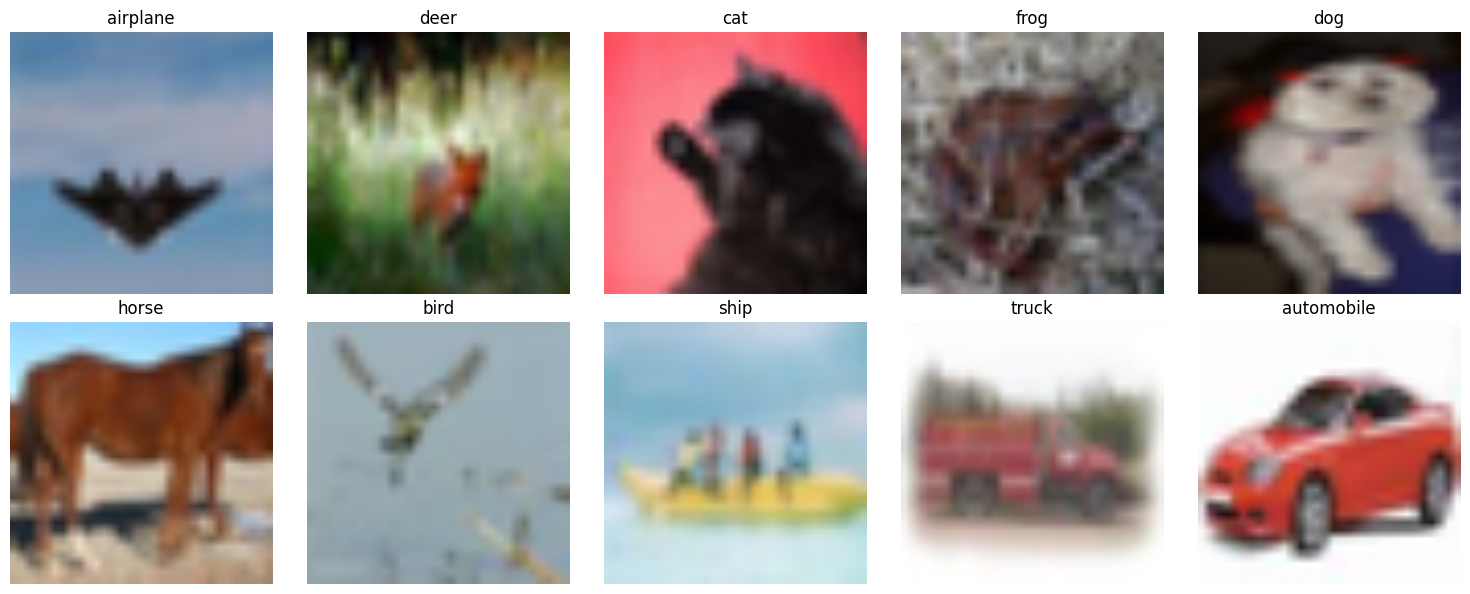

In [4]:
# Función para denormalizar las imágenes (revertir la normalización)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

class_examples = {}
# Buscar ejemplos aleatorios para cada clase
for images, labels in testloader:
    label = labels[0].item()
    class_name = classes[label]
    if class_name not in class_examples.keys():
        class_examples[class_name] = images[0]

# Crear subplots para visualizar las imágenes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Mostrar una imagen por cada clase en el subplot
for idx, (class_name, img) in enumerate(class_examples.items()):
    img = denormalize(img, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    img = np.transpose(img.numpy(), (1, 2, 0))  # Cambiar la forma a HWC para matplotlib
    axes[idx].imshow(img)
    axes[idx].set_title(class_name, fontsize='large')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 3. Definir la arquitectura de la CNN
En esta sección construimos una red convolucional sencilla compuesta por 2 capas convolucionales, cada una seguida de una capa de pooling, y 3 capas completamente conectadas que terminan en una salida del tamaño del conteo de clases en nuestra base de datos. Esta última especificación es de gran importancia al construir un modelo de clasificación, pues es lo que permite obtener una probabilidad asociada a cada categoría para finalmente presentar una predicción asociada a la imagen de entrada.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(SimpleCNN, self).__init__()
        
        # Definir las capas convolucionales
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 canales de entrada (RGB), 16 filtros, tamaño de kernel 3x3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 canales de entrada, 32 filtros, tamaño de kernel 3x3
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32 canales de entrada, 64 filtros, tamaño de kernel 3x3
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 64 canales de entrada, 128 filtros, tamaño de kernel 3x3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) # 128 canales de entrada, 256 filtros, tamaño de kernel 3x3
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1) # 256 canales de entrada, 512 filtros, tamaño de kernel 3x3
        
        # Definir las capas de pooling
        self.pool = nn.MaxPool2d(2, 2) # Max pooling con tamaño de ventana 2x2
        
        # Definir las capas completamente conectadas
        self.fc1 = nn.Linear(512 * 9, 256) # 512 canales de entrada, 256 salidas
        self.fc2 = nn.Linear(256, num_classes) # 256 entradas, num_classes salidas (clases)
        
        # Añadir dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x))) 
        x = self.pool(F.relu(self.conv6(x))) 
        
        x = x.view(x.size(0), -1) # Aplanar tensor
        
        x = F.relu(self.fc1(x)) # Primera capa completamente conectada + ReLU
        x = self.dropout(x) # Dropout
        x = self.fc2(x) # Segunda capa completamente conectada (salida)
        
        return x


## Declarar modelo

Una vez planeamos la arquitectura del modelo lo declaramos considerando los parámetros necesarios (en este caso, el número de clases y la probabilidad de dropout deseada). 

In [6]:
dropout = 0.5
model = SimpleCNN(num_classes=len(classes), dropout=dropout).to(device)
print("CNN declarada en la variable 'model'")

CNN declarada en la variable 'model'


# 4. Definir la función de pérdida y el optimizador
Te invitamos a experimentar con distintos valores para los siguientes parámetros y evaluar cómo afectan el entrenamiento y el desempeño del modelo.

In [7]:
# Definir criterio de pérdida: teniendo en cuenta que estamos tratando una tarea de clasificación, usamos Cross Entropy Loss.
criterion = nn.CrossEntropyLoss()
# Definir optimizador
learning_rate = 0.0005
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# 5. Ciclo de entrenamiento
La función de `train_model` presenta el ciclo de entrenamiento desde el recorrifo por el dataloader completo y la obtención de las predicciones correspondientes a cada batch para calcular la pérdida del modelo, hasta el proceso de validación. Durante la validación evaluamos de manera preliminar la habilidad de clasificación del modelo para con ello poder analizar la posible presencia de overfitting y asegurarnos de guardar los pesos correspondientes al estado óptimo de la red.

In [8]:
def train_model(model, epochs, train_dataloader, valid_dataloader, loss_criterion, optimizer, device):

    # Listas para registrar el loss y el accuracy a lo largo del ciclo de entrenamiento, incluyendo validación
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    
    # Inicializar variable para comparar desempeño del modelo durante validación entre épocas
    best_val_accuracy = 0.0
    best_model_wts = None

    for epoch in range(epochs): 
        model.train()  # Nos aseguramos de que el modelo esté en modo de entrenamiento
        
        # Variables para registrar desempeño del modelo a lo largo de toda la época
        batch_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterar sobre el conjunto de entrenamiento
        for data in tqdm(train_dataloader):
            inputs, labels = data[0].to(device), data[1].to(device)  # Obtener los inputs y labels del batch actual
            optimizer.zero_grad()  # Limpiar los gradientes de los parámetros optimizados
            outputs = model(inputs)  # Hacer una pasada hacia adelante (forward pass)
            loss = loss_criterion(outputs, labels)  # Calcular la pérdida entre las predicciones y las etiquetas reales
            loss.backward()  # Hacer la pasada hacia atrás o retropropagación (backward pass) para calcular los gradientes
            optimizer.step()  # Actualizar los parámetros del modelo usando los gradientes calculados
            
            batch_loss += loss.item()  # Acumular la pérdida del batch actual
            _, predicted = torch.max(outputs.data, 1)  # Obtener las predicciones del modelo tomando la clase con mayor probabilidad para cada dato
            total_train += labels.size(0)  # Incrementar el conteo total de muestras procesadas
            correct_train += (predicted == labels).sum().item()  # Contar las predicciones correctas

        train_loss = batch_loss / len(train_dataloader)  # Calcular la pérdida media para la época
        train_accuracy = 100 * correct_train / total_train  # Calcular la precisión para la época

        # Validar el modelo al final de la época
        model.eval()  # Poner el modelo en modo de evaluación
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Desactivar el cálculo de gradientes para la validación
            for data in tqdm(valid_dataloader):
                inputs, labels = data[0].to(device), data[1].to(device) # Obtener los inputs y labels del batch de validación
                outputs = model(inputs)  # Hacer una pasada hacia adelante (forward pass)
                loss = loss_criterion(outputs, labels)  # Calcular la pérdida entre las predicciones y las etiquetas reales
                val_loss += loss.item()  # Acumular la pérdida del batch de validación
                _, predicted = torch.max(outputs.data, 1)  # Obtener las predicciones del modelo
                total_val += labels.size(0)  # Incrementar el conteo total de muestras procesadas
                correct_val += (predicted == labels).sum().item()  # Contar las predicciones correctas

        val_loss = val_loss / len(valid_dataloader)  # Calcular la pérdida media para el conjunto de validación
        val_accuracy = 100 * correct_val / total_val  # Calcular la precisión para el conjunto de validación

        # Imprimir estadísticas por época
        print(f'Epoch [{epoch + 1}/{epochs}]\n'
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n'
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        # Guardar el modelo si mejora la precisión en el conjunto de validación
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_model.pth')
            best_model_wts = model.state_dict()
            print(f'** Model checkpoints from epoch {epoch+1} with accuracy of {val_accuracy:.2f}% saved in "best_model.pth" **')
        
        print('---'*30)
        # Registrar desempeño de la época
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

    print('Finished Training')
    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)

    return train_losses, train_accuracies, valid_losses, valid_accuracies, model

In [9]:
def plot_results(losses: tuple, accuracies: tuple, titles: list):
    """
    Esta función recibe los valores de pérdida y de accuracy registrados durante el entrenamiento y la validación
    para presentar el gráfico de estos valores a lo largo de las épocas.
    """

    epochs = range(1, len(losses[0]) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot losses
    for set in range(len(losses)):
        axs[0].plot(epochs, losses[set], label=titles[set], marker='o')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot accuracies
    for set in range(len(losses)):
        axs[1].plot(epochs, accuracies[set], label=titles[set], marker='o')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

### Entrenar modelo y retornar registro del proceso

100%|██████████| 282/282 [00:07<00:00, 35.63it/s]


Epoch [1/18]
Train Loss: 2.3020, Train Accuracy: 11.20%
Validation Loss: 2.3008, Validation Accuracy: 9.72%
** Model checkpoints from epoch 1 with accuracy of 9.72% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.31it/s]


Epoch [2/18]
Train Loss: 2.2726, Train Accuracy: 13.72%
Validation Loss: 2.1182, Validation Accuracy: 25.48%
** Model checkpoints from epoch 2 with accuracy of 25.48% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.32it/s]


Epoch [3/18]
Train Loss: 1.9947, Train Accuracy: 27.86%
Validation Loss: 1.8155, Validation Accuracy: 34.84%
** Model checkpoints from epoch 3 with accuracy of 34.84% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.66it/s]


Epoch [4/18]
Train Loss: 1.7525, Train Accuracy: 36.48%
Validation Loss: 1.6175, Validation Accuracy: 40.79%
** Model checkpoints from epoch 4 with accuracy of 40.79% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.83it/s]


Epoch [5/18]
Train Loss: 1.5928, Train Accuracy: 42.08%
Validation Loss: 1.5404, Validation Accuracy: 43.90%
** Model checkpoints from epoch 5 with accuracy of 43.90% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.07it/s]


Epoch [6/18]
Train Loss: 1.4825, Train Accuracy: 46.86%
Validation Loss: 1.4361, Validation Accuracy: 48.88%
** Model checkpoints from epoch 6 with accuracy of 48.88% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.00it/s]


Epoch [7/18]
Train Loss: 1.3856, Train Accuracy: 50.72%
Validation Loss: 1.3155, Validation Accuracy: 53.83%
** Model checkpoints from epoch 7 with accuracy of 53.83% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.01it/s]


Epoch [8/18]
Train Loss: 1.2848, Train Accuracy: 54.17%
Validation Loss: 1.2305, Validation Accuracy: 56.39%
** Model checkpoints from epoch 8 with accuracy of 56.39% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.42it/s]


Epoch [9/18]
Train Loss: 1.1917, Train Accuracy: 57.92%
Validation Loss: 1.1644, Validation Accuracy: 60.02%
** Model checkpoints from epoch 9 with accuracy of 60.02% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.74it/s]


Epoch [10/18]
Train Loss: 1.1044, Train Accuracy: 61.22%
Validation Loss: 1.1009, Validation Accuracy: 62.07%
** Model checkpoints from epoch 10 with accuracy of 62.07% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.46it/s]


Epoch [11/18]
Train Loss: 1.0266, Train Accuracy: 64.19%
Validation Loss: 1.0822, Validation Accuracy: 61.72%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.83it/s]


Epoch [12/18]
Train Loss: 0.9559, Train Accuracy: 66.43%
Validation Loss: 1.0182, Validation Accuracy: 64.29%
** Model checkpoints from epoch 12 with accuracy of 64.29% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.30it/s]


Epoch [13/18]
Train Loss: 0.8887, Train Accuracy: 68.98%
Validation Loss: 1.0304, Validation Accuracy: 64.87%
** Model checkpoints from epoch 13 with accuracy of 64.87% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.75it/s]


Epoch [14/18]
Train Loss: 0.8212, Train Accuracy: 71.22%
Validation Loss: 0.9625, Validation Accuracy: 67.26%
** Model checkpoints from epoch 14 with accuracy of 67.26% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.32it/s]


Epoch [15/18]
Train Loss: 0.7584, Train Accuracy: 73.35%
Validation Loss: 0.9569, Validation Accuracy: 67.58%
** Model checkpoints from epoch 15 with accuracy of 67.58% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.12it/s]


Epoch [16/18]
Train Loss: 0.6977, Train Accuracy: 75.62%
Validation Loss: 0.9543, Validation Accuracy: 68.42%
** Model checkpoints from epoch 16 with accuracy of 68.42% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.25it/s]


Epoch [17/18]
Train Loss: 0.6373, Train Accuracy: 77.21%
Validation Loss: 0.9421, Validation Accuracy: 69.14%
** Model checkpoints from epoch 17 with accuracy of 69.14% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.26it/s]


Epoch [18/18]
Train Loss: 0.5729, Train Accuracy: 79.69%
Validation Loss: 1.0056, Validation Accuracy: 68.38%
------------------------------------------------------------------------------------------
Finished Training


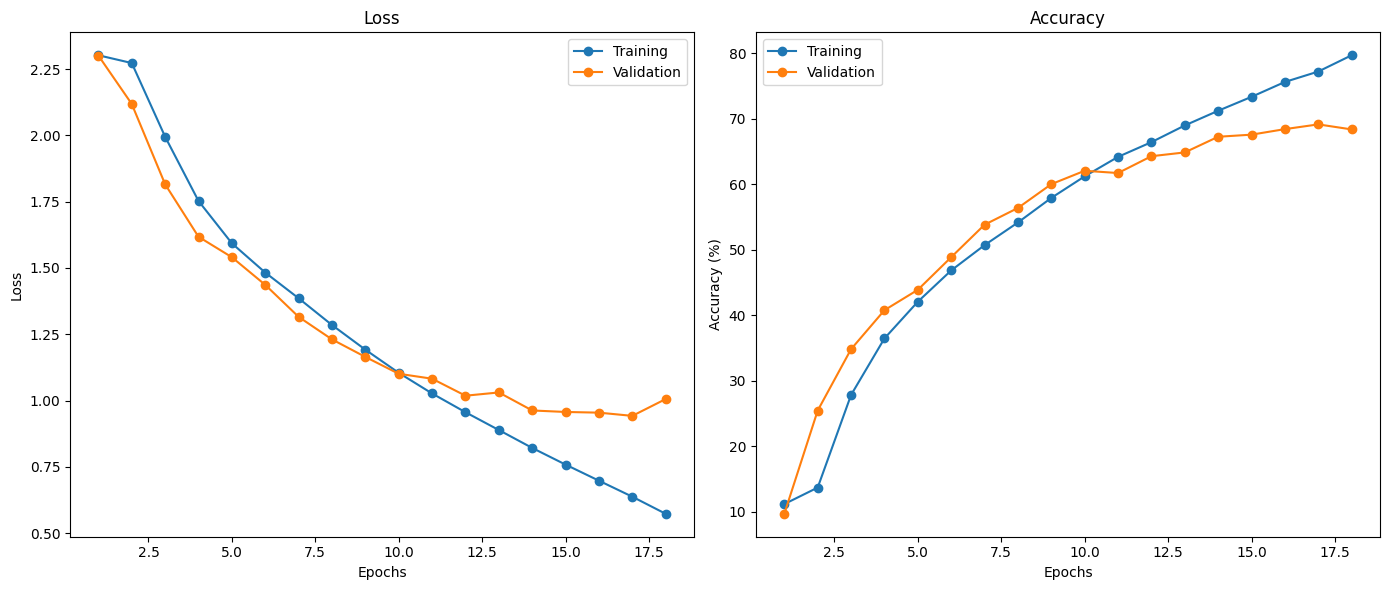

In [10]:
# Establecer cantidad de épocas de entrenamiento
num_epochs = 18 # Puedes experimentar aumentando el número de épocas de entrenamiento, especialmente si observas que el modelo no ha convergido con la cantidad actual.

# Entrenar modelo
train_output = train_model(
    model=model, 
    epochs=num_epochs, 
    train_dataloader=trainloader,
    valid_dataloader=valloader, 
    loss_criterion=criterion, 
    optimizer=optimizer, 
    device=device
    )

train_losses, train_accuracies, valid_losses, valid_accuracies, model = train_output
model = model.to(device)
plot_results((train_losses, valid_losses), (train_accuracies, valid_accuracies), titles = ['Training', 'Validation'])

# 6. Evaluación de modelo entrenado
Una vez hemos entrenado nuestro modelo debemos observar su comportamiento con datos nunca antes vistos, por lo que evaluamos con el conjunto de datos de test. La siguiente función recorre el dataloader de evaluación completo y presenta el desempeño de la red considerando métricas como el accuracy, la precisión, la cobertura y la medida F1 de las predicciones. Además, se presenta la matriz de confusión para poder diferenciar con mayor claridad el desempeño en las clases individuales.

In [11]:

def test_model(model, test_dataloader):
    model.eval()  # Poner el modelo en modo evaluación
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Desactivar el cálculo de gradientes para la evaluación
        for data in tqdm(test_dataloader):
            inputs, labels = data[0].to(device), data[1].to(device)  
            outputs = model(inputs)  
            _, predicted = torch.max(outputs.data, 1)  # Obtener las predicciones del modelo
            
            all_labels.extend(labels.cpu().numpy())  # Almacenar etiquetas reales
            all_preds.extend(predicted.cpu().numpy())  # Almacenar predicciones

    # Calcular las métricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Imprimir las métricas
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    
    # Plotear matriz de confusión
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predictions')
    plt.ylabel('True classes')
    plt.title('Confusion Matrix')
    plt.show()

### Evaluar modelo entrenado de CNN

100%|██████████| 282/282 [00:07<00:00, 36.13it/s]


Accuracy: 0.68
Precision: 0.67
Recall: 0.68
F1 Score: 0.67
Confusion Matrix:


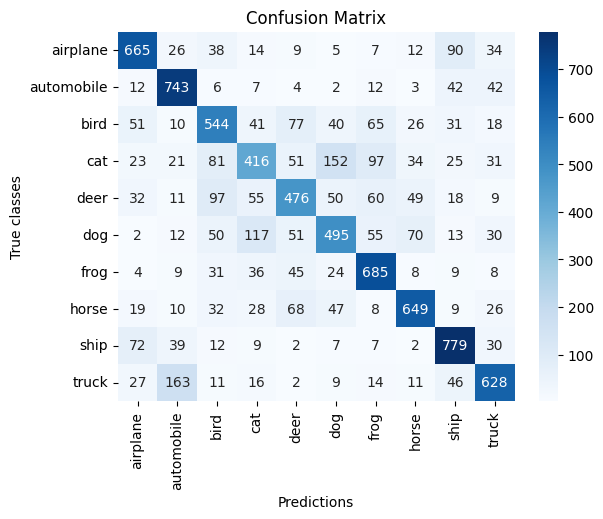

In [12]:
test_model(model=model, test_dataloader=testloader)

# 6.1. Visualizar predicciones del modelo entrenado

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


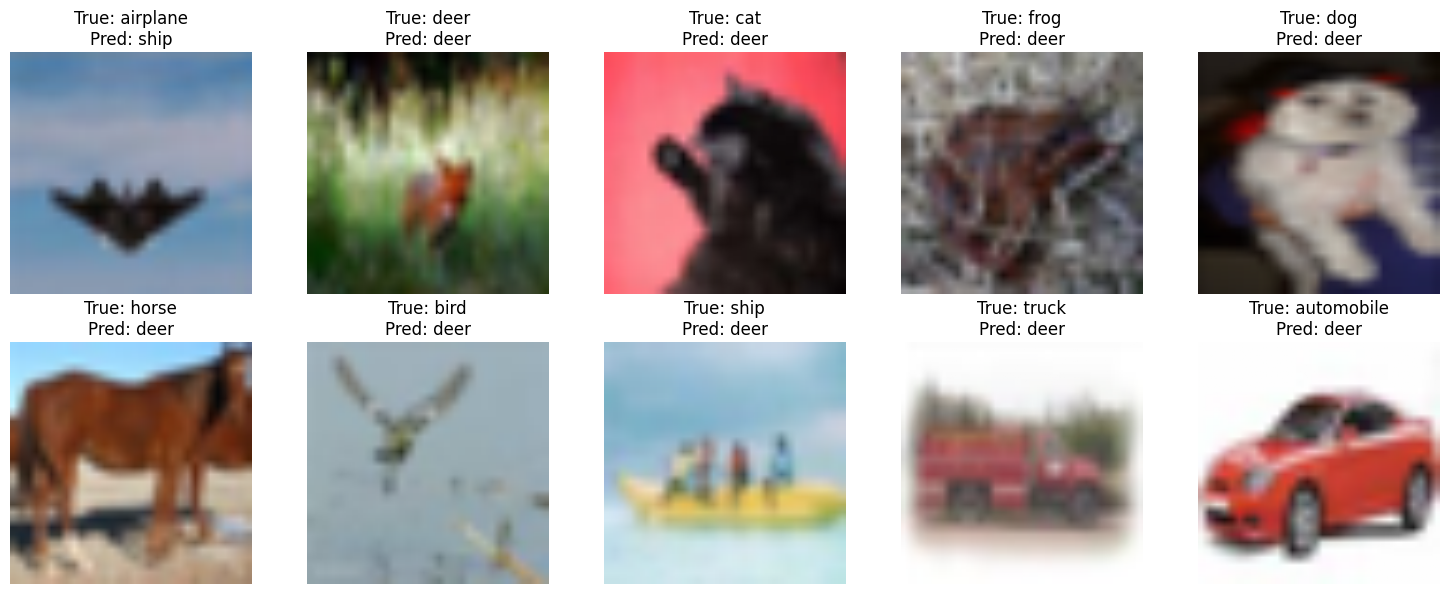

In [13]:
# Crear subplots para visualizar las imágenes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Desactivar gradientes para la inferencia
with torch.no_grad():
    for idx, (class_name, img) in enumerate(class_examples.items()):
        img_batch = img.unsqueeze(0) 
        output = model(img_batch.to(device))  # Obtener la predicción del modelo
        _, predicted = torch.max(output, 1)  
        predicted_class = classes[predicted.item()]  

        #img = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = np.transpose(img.numpy(), (1, 2, 0))  

        axes[idx].imshow(img)
        axes[idx].set_title(f'True: {class_name}\nPred: {predicted_class}', fontsize='large')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Preguntas guía opcionales:
**1.** Explora agregar o remover capas convolucionales del modelo. **¿Cómo afecta esto el desempeño de la red convolucional?**

**2.** Agrega o elimina capas completamente conectadas. **¿Cómo afecta esto el desempeño de la red convolucional? ¿Tiene el mismo efecto que modificar la cantidad de capas convolucionales?**

**3.** Usa la librería [torchsummary](https://pypi.org/project/torch-summary/) para comparar el tamaño de los modelos que planeaste en los otros puntos. **¿Qué cambios en la arquitectura de la red afectan más el tamaño del modelo (cantidad de parámetros a entrenar)?**

**4.** En las lecciones de la semana 4 estudiamos una serie de técnicas de regulación que reducen el sobreajuste en las redes convolucionales, entre ellas el dropout. **Modifica el dropout del modelo y analiza la relación entre este páramentro y las habilidades de la CNN.**

**5.** Aplica alguna de las otras **técnicas de regularización** para entender su utilidad en el proceso de entrenar un modelo con mayor capacidad de generalización.

### 1. Agregar capas convolucionales

Exploremos el efecto de agregar capas convolucionales al modelo de `SimpleCNN`. En el modelo original, teníamos seis capas convolucionales y ahora agregaremos una capa adicionales. Los cambios realizados son los siguentes:

**Capas Convolucionales**
* `conv7`: Esta capa toma como entrada los 512 canales generados por la capa anterior (conv6) y aplica 1024 filtros con un tamaño de kernel de 3x3.

**Capas Completamente Conectadas**

Debido a que se agregó una capa convolucional, el número de canales de entrada a la primera capa completamente conectada (`fc1`) se debe ajustar a este cambio (de `512x9` a `1024x1`).
* El cambio de 512 a 1024 en `fc1` refleja el aumento en el número de filtros utilizados en la última capa convolucional.
* El cambio de 9 a 1 refleja la reducción en el tamaño espacial de los mapas de características debido a la operación de pooling adicional.

**Modificación del forward**

La función `forward` ha sido modificado para incluir las nueva capa `conv7`, asegurando que los datos pasen por estas capas adicionales antes de llegar a la primera capa completamente conectada. 



In [14]:
class SimpleCNN_Mod1(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(SimpleCNN_Mod1, self).__init__()
        
        # Definir las capas convolucionales
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 canales de entrada (RGB), 16 filtros, tamaño de kernel 3x3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 canales de entrada, 32 filtros, tamaño de kernel 3x3
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32 canales de entrada, 64 filtros, tamaño de kernel 3x3
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 64 canales de entrada, 128 filtros, tamaño de kernel 3x3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) # 128 canales de entrada, 256 filtros, tamaño de kernel 3x3
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1) # 256 canales de entrada, 512 filtros, tamaño de kernel 3x3
        self.conv7 = nn.Conv2d(512, 1024, 3, padding=1) # 512 canales de entrada, 1024 filtros, tamaño de kernel 3x3

        # Definir las capas de pooling
        self.pool = nn.MaxPool2d(2, 2) # Max pooling con tamaño de ventana 2x2
        
        # Definir las capas completamente conectadas
        self.fc1 = nn.Linear(1024 * 1, 256) # 1024 canales de entrada, 256 salidas
        self.fc2 = nn.Linear(256, num_classes) # 256 entradas, num_classes salidas (clases)
        
        # Añadir dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x))) 
        x = self.pool(F.relu(self.conv6(x))) 
        x = self.pool(F.relu(self.conv7(x))) 
        
        x = x.view(x.size(0), -1) # Aplanar tensor
        
        x = F.relu(self.fc1(x)) # Primera capa completamente conectada + ReLU
        x = self.dropout(x) # Dropout
        x = self.fc2(x) # Segunda capa completamente conectada (salida)
        
        return x

Ahora entrenamos y evaluamos el modelo modificado siguiendo los mismo pasos utilizamos en nuestra red neuronal convolucional original. 

CNN declarada en la variable ''model_mod1'


100%|██████████| 282/282 [00:07<00:00, 36.54it/s]


Epoch [1/18]
Train Loss: 2.3029, Train Accuracy: 10.24%
Validation Loss: 2.3025, Validation Accuracy: 9.90%
** Model checkpoints from epoch 1 with accuracy of 9.90% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.56it/s]


Epoch [2/18]
Train Loss: 2.3023, Train Accuracy: 10.39%
Validation Loss: 2.3021, Validation Accuracy: 9.90%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.38it/s]


Epoch [3/18]
Train Loss: 2.3014, Train Accuracy: 11.52%
Validation Loss: 2.3005, Validation Accuracy: 14.77%
** Model checkpoints from epoch 3 with accuracy of 14.77% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.23it/s]


Epoch [4/18]
Train Loss: 2.2922, Train Accuracy: 14.54%
Validation Loss: 2.2571, Validation Accuracy: 15.36%
** Model checkpoints from epoch 4 with accuracy of 15.36% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.79it/s]


Epoch [5/18]
Train Loss: 2.1478, Train Accuracy: 21.91%
Validation Loss: 1.9977, Validation Accuracy: 29.24%
** Model checkpoints from epoch 5 with accuracy of 29.24% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.46it/s]


Epoch [6/18]
Train Loss: 1.9488, Train Accuracy: 29.89%
Validation Loss: 1.8626, Validation Accuracy: 34.00%
** Model checkpoints from epoch 6 with accuracy of 34.00% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.79it/s]


Epoch [7/18]
Train Loss: 1.8466, Train Accuracy: 33.55%
Validation Loss: 1.7632, Validation Accuracy: 37.03%
** Model checkpoints from epoch 7 with accuracy of 37.03% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.37it/s]


Epoch [8/18]
Train Loss: 1.7462, Train Accuracy: 36.77%
Validation Loss: 1.6578, Validation Accuracy: 40.22%
** Model checkpoints from epoch 8 with accuracy of 40.22% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.35it/s]


Epoch [9/18]
Train Loss: 1.6513, Train Accuracy: 40.38%
Validation Loss: 1.5735, Validation Accuracy: 43.62%
** Model checkpoints from epoch 9 with accuracy of 43.62% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.33it/s]


Epoch [10/18]
Train Loss: 1.5527, Train Accuracy: 44.32%
Validation Loss: 1.4765, Validation Accuracy: 47.39%
** Model checkpoints from epoch 10 with accuracy of 47.39% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.43it/s]


Epoch [11/18]
Train Loss: 1.4537, Train Accuracy: 48.29%
Validation Loss: 1.4285, Validation Accuracy: 49.04%
** Model checkpoints from epoch 11 with accuracy of 49.04% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.43it/s]


Epoch [12/18]
Train Loss: 1.3790, Train Accuracy: 50.99%
Validation Loss: 1.3308, Validation Accuracy: 52.30%
** Model checkpoints from epoch 12 with accuracy of 52.30% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.48it/s]


Epoch [13/18]
Train Loss: 1.3047, Train Accuracy: 53.73%
Validation Loss: 1.2999, Validation Accuracy: 53.91%
** Model checkpoints from epoch 13 with accuracy of 53.91% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.00it/s]


Epoch [14/18]
Train Loss: 1.2233, Train Accuracy: 56.36%
Validation Loss: 1.3372, Validation Accuracy: 53.33%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.55it/s]


Epoch [15/18]
Train Loss: 1.1522, Train Accuracy: 59.25%
Validation Loss: 1.1864, Validation Accuracy: 57.24%
** Model checkpoints from epoch 15 with accuracy of 57.24% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.63it/s]


Epoch [16/18]
Train Loss: 1.0723, Train Accuracy: 61.89%
Validation Loss: 1.1472, Validation Accuracy: 59.99%
** Model checkpoints from epoch 16 with accuracy of 59.99% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.78it/s]


Epoch [17/18]
Train Loss: 1.0008, Train Accuracy: 64.73%
Validation Loss: 1.1183, Validation Accuracy: 60.59%
** Model checkpoints from epoch 17 with accuracy of 60.59% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.47it/s]


Epoch [18/18]
Train Loss: 0.9254, Train Accuracy: 67.43%
Validation Loss: 1.0876, Validation Accuracy: 63.08%
** Model checkpoints from epoch 18 with accuracy of 63.08% saved in "best_model.pth" **
------------------------------------------------------------------------------------------
Finished Training


100%|██████████| 282/282 [00:08<00:00, 34.51it/s]


Accuracy: 0.63
Precision: 0.64
Recall: 0.63
F1 Score: 0.63
Confusion Matrix:


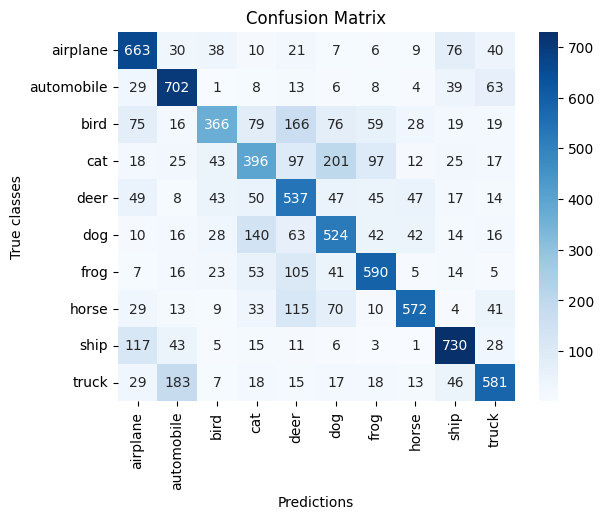

In [15]:
# Definir el modelo
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
dropout = 0.5
model_mod1 = SimpleCNN_Mod1(num_classes=len(classes), dropout=dropout).to(device)
print("CNN declarada en la variable ''model_mod1'")

# Definir criterio de pérdida: teniendo en cuenta que estamos tratando una tarea de clasificación, usamos Cross Entropy Loss.
criterion = nn.CrossEntropyLoss()

# Definir optimizador
learning_rate = 0.0005
momentum = 0.9
optimizer = optim.SGD(model_mod1.parameters(), lr=learning_rate, momentum=momentum)

# Establecer cantidad de épocas de entrenamiento
num_epochs = 18 # Puedes experimentar aumentando el número de épocas de entrenamiento, especialmente si observas que el modelo no ha convergido con la cantidad actual.

# Entrenar modelo
train_output = train_model(
    model=model_mod1, 
    epochs=num_epochs, 
    train_dataloader=trainloader,
    valid_dataloader=valloader, 
    loss_criterion=criterion, 
    optimizer=optimizer, 
    device=device
    )

train_losses, train_accuracies, valid_losses, valid_accuracies, model_mod1 = train_output
model_mod1 = model_mod1.to(device)

# Evaluar el rendimiento del modelo
test_model(model=model_mod1, test_dataloader=testloader)

### 1. Remover capas convolucionales

Exploremos ahora el efecto de remover capas convolucionales al modelo de `SimpleCNN`. En el modelo original, teníamos seis capas convolucionales y ahora vamos a eliminar dos capas. Los cambios realizados son los siguentes:

**Capas Convolucionales**
* Se eliminaron `conv5` y `conv6`, reduciendo la cantidad total de capas convolucionales a cuatro.
* Como resultado, la capa `conv4` ahora es la última capa convolucional, con 128 filtros.

**Capas Completamente Conectadas**

Debido a que se eliminaron dos capas convolucionales, el número de canales de entrada a la primera capa completamente conectada (`fc1`) se debe ajustar a este cambio (de `512x9` a `128x196`).
* El cambio de 512 a 128 en `fc1` refleja la reducción en el número de filtros utilizados en la última capa convolucional.
* El cambio de 9 a 196 refleja el aumento en el tamaño espacial de los mapas de características, dado que se eliminarion dos operaciones de pooling.

**Modificación del forward**

La función `forward` ha sido simplificado al remover las capas `conv5` y `conv6`, de manera que los datos ahora pasan directamente desde `conv4` a las capas completamente conectadas.

In [16]:
class SimpleCNN_Mod2(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(SimpleCNN_Mod2, self).__init__()
        
        # Definir las capas convolucionales
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 canales de entrada (RGB), 16 filtros, tamaño de kernel 3x3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 canales de entrada, 32 filtros, tamaño de kernel 3x3
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32 canales de entrada, 64 filtros, tamaño de kernel 3x3
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 64 canales de entrada, 128 filtros, tamaño de kernel 3x3
        
        # Definir las capas de pooling
        self.pool = nn.MaxPool2d(2, 2) # Max pooling con tamaño de ventana 2x2
        
        # Definir las capas completamente conectadas
        self.fc1 = nn.Linear(128 * 196, 256) # 128 canales de entrada, 256 salidas
        self.fc2 = nn.Linear(256, num_classes) # 256 entradas, num_classes salidas (clases)
        
        # Añadir dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(x.size(0), -1) # Aplanar tensor
        
        x = F.relu(self.fc1(x)) # Primera capa completamente conectada + ReLU
        x = self.dropout(x) # Dropout
        x = self.fc2(x) # Segunda capa completamente conectada (salida)
        
        return x

Ahora entrenamos y evaluamos el modelo modificado siguiendo los mismo pasos utilizamos en nuestra red neuronal convolucional original. 

CNN declarada en la variable 'model_mod2'


100%|██████████| 282/282 [00:07<00:00, 35.43it/s]


Epoch [1/18]
Train Loss: 2.0686, Train Accuracy: 25.26%
Validation Loss: 1.7785, Validation Accuracy: 37.28%
** Model checkpoints from epoch 1 with accuracy of 37.28% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.06it/s]


Epoch [2/18]
Train Loss: 1.7012, Train Accuracy: 39.48%
Validation Loss: 1.5316, Validation Accuracy: 45.92%
** Model checkpoints from epoch 2 with accuracy of 45.92% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.63it/s]


Epoch [3/18]
Train Loss: 1.4934, Train Accuracy: 46.60%
Validation Loss: 1.3623, Validation Accuracy: 50.57%
** Model checkpoints from epoch 3 with accuracy of 50.57% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.03it/s]


Epoch [4/18]
Train Loss: 1.3688, Train Accuracy: 51.07%
Validation Loss: 1.2812, Validation Accuracy: 54.23%
** Model checkpoints from epoch 4 with accuracy of 54.23% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.06it/s]


Epoch [5/18]
Train Loss: 1.2864, Train Accuracy: 54.14%
Validation Loss: 1.2499, Validation Accuracy: 56.16%
** Model checkpoints from epoch 5 with accuracy of 56.16% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.24it/s]


Epoch [6/18]
Train Loss: 1.2176, Train Accuracy: 56.64%
Validation Loss: 1.1794, Validation Accuracy: 58.78%
** Model checkpoints from epoch 6 with accuracy of 58.78% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.15it/s]


Epoch [7/18]
Train Loss: 1.1447, Train Accuracy: 59.40%
Validation Loss: 1.1391, Validation Accuracy: 59.53%
** Model checkpoints from epoch 7 with accuracy of 59.53% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.70it/s]


Epoch [8/18]
Train Loss: 1.0762, Train Accuracy: 61.82%
Validation Loss: 1.0994, Validation Accuracy: 61.18%
** Model checkpoints from epoch 8 with accuracy of 61.18% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.74it/s]


Epoch [9/18]
Train Loss: 1.0113, Train Accuracy: 63.96%
Validation Loss: 1.0576, Validation Accuracy: 62.96%
** Model checkpoints from epoch 9 with accuracy of 62.96% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.98it/s]


Epoch [10/18]
Train Loss: 0.9415, Train Accuracy: 66.73%
Validation Loss: 1.0461, Validation Accuracy: 63.44%
** Model checkpoints from epoch 10 with accuracy of 63.44% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.10it/s]


Epoch [11/18]
Train Loss: 0.8793, Train Accuracy: 68.98%
Validation Loss: 1.0010, Validation Accuracy: 65.43%
** Model checkpoints from epoch 11 with accuracy of 65.43% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.50it/s]


Epoch [12/18]
Train Loss: 0.8062, Train Accuracy: 71.44%
Validation Loss: 0.9985, Validation Accuracy: 65.61%
** Model checkpoints from epoch 12 with accuracy of 65.61% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.58it/s]


Epoch [13/18]
Train Loss: 0.7339, Train Accuracy: 73.73%
Validation Loss: 0.9698, Validation Accuracy: 66.70%
** Model checkpoints from epoch 13 with accuracy of 66.70% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.28it/s]


Epoch [14/18]
Train Loss: 0.6677, Train Accuracy: 76.22%
Validation Loss: 0.9666, Validation Accuracy: 67.20%
** Model checkpoints from epoch 14 with accuracy of 67.20% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.07it/s]


Epoch [15/18]
Train Loss: 0.6094, Train Accuracy: 78.34%
Validation Loss: 1.0083, Validation Accuracy: 67.16%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.68it/s]


Epoch [16/18]
Train Loss: 0.5435, Train Accuracy: 80.49%
Validation Loss: 1.0604, Validation Accuracy: 66.59%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.38it/s]


Epoch [17/18]
Train Loss: 0.4824, Train Accuracy: 82.78%
Validation Loss: 1.0659, Validation Accuracy: 67.11%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 36.77it/s]


Epoch [18/18]
Train Loss: 0.4275, Train Accuracy: 84.73%
Validation Loss: 1.0814, Validation Accuracy: 67.56%
** Model checkpoints from epoch 18 with accuracy of 67.56% saved in "best_model.pth" **
------------------------------------------------------------------------------------------
Finished Training


100%|██████████| 282/282 [00:07<00:00, 35.95it/s]


Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1 Score: 0.67
Confusion Matrix:


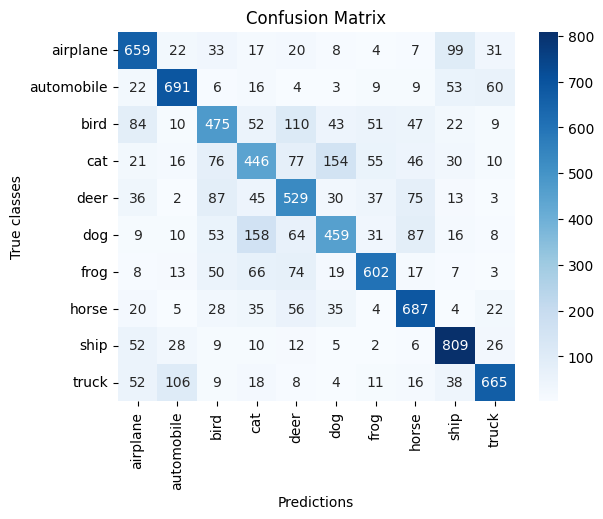

In [17]:
# Definir el modelo
dropout = 0.5
model_mod2 = SimpleCNN_Mod2(num_classes=len(classes), dropout=dropout).to(device)
print("CNN declarada en la variable 'model_mod2'")

# Definir criterio de pérdida: teniendo en cuenta que estamos tratando una tarea de clasificación, usamos Cross Entropy Loss.
criterion = nn.CrossEntropyLoss()

# Definir optimizador
learning_rate = 0.0005
momentum = 0.9
optimizer = optim.SGD(model_mod2.parameters(), lr=learning_rate, momentum=momentum)

# Establecer cantidad de épocas de entrenamiento
num_epochs = 18 # Puedes experimentar aumentando el número de épocas de entrenamiento, especialmente si observas que el modelo no ha convergido con la cantidad actual.

# Entrenar modelo
train_output = train_model(
    model=model_mod2, 
    epochs=num_epochs, 
    train_dataloader=trainloader,
    valid_dataloader=valloader, 
    loss_criterion=criterion, 
    optimizer=optimizer, 
    device=device
    )

train_losses, train_accuracies, valid_losses, valid_accuracies, model_mod2 = train_output
model_mod2 = model_mod2.to(device)

# Evaluar el rendimiento del modelo
test_model(model=model_mod2, test_dataloader=testloader)

### 2. Agregar capas completamente conectadas

Exploremos el efecto de agregar capas completamente conectadas al modelo de `SimpleCNN`. En el modelo original, teníamos dos capas completamente conectadas y ahora agregaremos una capa adicional. Los cambios realizados son los siguientes:

**Capas Completamente Conectadas**
* Se añadió una nueva capa completamente conectada, `fc_additional`, con 128 unidades entre `fc1` y `fc2`.
* Ahora, el flujo de datos pasa por tres capas completamente conectadas: `fc1`, `fc_additional`, y `fc2`.

**Modificación del forward**

La función `forward` ha sido actualizada para incluir la nueva capa `fc_additional`, de modo que los datos, después de pasar por `fc1`, son procesados por esta nueva capa antes de llegar a `fc2`.

In [23]:
class SimpleCNN_Mod3(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(SimpleCNN_Mod3, self).__init__()
        
        # Definir las capas convolucionales
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 canales de entrada (RGB), 16 filtros, tamaño de kernel 3x3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 canales de entrada, 32 filtros, tamaño de kernel 3x3
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32 canales de entrada, 64 filtros, tamaño de kernel 3x3
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 64 canales de entrada, 128 filtros, tamaño de kernel 3x3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) # 128 canales de entrada, 256 filtros, tamaño de kernel 3x3
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1) # 256 canales de entrada, 512 filtros, tamaño de kernel 3x3
        
        # Definir las capas de pooling
        self.pool = nn.MaxPool2d(2, 2) # Max pooling con tamaño de ventana 2x2
        
        # Definir las capas completamente conectadas
        self.fc1 = nn.Linear(512 * 9, 256) # 512 canales de entrada, 256 salidas
        self.fc_additional = nn.Linear(256, 128) # Nueva capa completamente conectada con 128 unidades
        self.fc2 = nn.Linear(128, num_classes) # 128 entradas, num_classes salidas (clases)
        
        # Añadir dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x))) 
        x = self.pool(F.relu(self.conv6(x))) 
        
        x = x.view(x.size(0), -1) # Aplanar tensor
        
        x = F.relu(self.fc1(x)) # Primera capa completamente conectada + ReLU
        x = F.relu(self.fc_additional(x)) # Nueva capa completamente conectada + ReLU
        x = self.dropout(x) # Dropout
        x = self.fc2(x) # Segunda capa completamente conectada (salida)
        
        return x

Ahora entrenamos y evaluamos el modelo modificado siguiendo los mismo pasos utilizamos en nuestra red neuronal convolucional original. 

CNN declarada en la variable ''model_mod3'


100%|██████████| 282/282 [00:08<00:00, 33.03it/s]


Epoch [1/18]
Train Loss: 2.3031, Train Accuracy: 10.02%
Validation Loss: 2.3026, Validation Accuracy: 9.72%
** Model checkpoints from epoch 1 with accuracy of 9.72% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.89it/s]


Epoch [2/18]
Train Loss: 2.3025, Train Accuracy: 10.31%
Validation Loss: 2.3023, Validation Accuracy: 9.73%
** Model checkpoints from epoch 2 with accuracy of 9.73% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.93it/s]


Epoch [3/18]
Train Loss: 2.3021, Train Accuracy: 10.70%
Validation Loss: 2.3019, Validation Accuracy: 10.18%
** Model checkpoints from epoch 3 with accuracy of 10.18% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.90it/s]


Epoch [4/18]
Train Loss: 2.3012, Train Accuracy: 11.80%
Validation Loss: 2.2998, Validation Accuracy: 11.98%
** Model checkpoints from epoch 4 with accuracy of 11.98% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.27it/s]


Epoch [5/18]
Train Loss: 2.2898, Train Accuracy: 14.06%
Validation Loss: 2.2402, Validation Accuracy: 20.06%
** Model checkpoints from epoch 5 with accuracy of 20.06% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 32.76it/s]


Epoch [6/18]
Train Loss: 2.0949, Train Accuracy: 23.06%
Validation Loss: 1.9806, Validation Accuracy: 29.46%
** Model checkpoints from epoch 6 with accuracy of 29.46% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 32.97it/s]


Epoch [7/18]
Train Loss: 1.9042, Train Accuracy: 31.21%
Validation Loss: 1.8154, Validation Accuracy: 34.61%
** Model checkpoints from epoch 7 with accuracy of 34.61% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.59it/s]


Epoch [8/18]
Train Loss: 1.7663, Train Accuracy: 36.57%
Validation Loss: 1.6714, Validation Accuracy: 40.16%
** Model checkpoints from epoch 8 with accuracy of 40.16% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.24it/s]


Epoch [9/18]
Train Loss: 1.6457, Train Accuracy: 41.22%
Validation Loss: 1.5923, Validation Accuracy: 43.36%
** Model checkpoints from epoch 9 with accuracy of 43.36% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.65it/s]


Epoch [10/18]
Train Loss: 1.5401, Train Accuracy: 45.15%
Validation Loss: 1.4655, Validation Accuracy: 47.33%
** Model checkpoints from epoch 10 with accuracy of 47.33% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.57it/s]


Epoch [11/18]
Train Loss: 1.4470, Train Accuracy: 48.91%
Validation Loss: 1.4229, Validation Accuracy: 49.26%
** Model checkpoints from epoch 11 with accuracy of 49.26% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.70it/s]


Epoch [12/18]
Train Loss: 1.3461, Train Accuracy: 52.65%
Validation Loss: 1.3380, Validation Accuracy: 53.18%
** Model checkpoints from epoch 12 with accuracy of 53.18% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.20it/s]


Epoch [13/18]
Train Loss: 1.2533, Train Accuracy: 56.13%
Validation Loss: 1.2619, Validation Accuracy: 55.87%
** Model checkpoints from epoch 13 with accuracy of 55.87% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.61it/s]


Epoch [14/18]
Train Loss: 1.1698, Train Accuracy: 59.54%
Validation Loss: 1.1843, Validation Accuracy: 59.61%
** Model checkpoints from epoch 14 with accuracy of 59.61% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.41it/s]


Epoch [15/18]
Train Loss: 1.0871, Train Accuracy: 62.23%
Validation Loss: 1.1454, Validation Accuracy: 61.14%
** Model checkpoints from epoch 15 with accuracy of 61.14% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.17it/s]


Epoch [16/18]
Train Loss: 1.0024, Train Accuracy: 65.20%
Validation Loss: 1.1038, Validation Accuracy: 62.91%
** Model checkpoints from epoch 16 with accuracy of 62.91% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.97it/s]


Epoch [17/18]
Train Loss: 0.9334, Train Accuracy: 67.66%
Validation Loss: 1.1619, Validation Accuracy: 61.19%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.84it/s]


Epoch [18/18]
Train Loss: 0.8518, Train Accuracy: 70.49%
Validation Loss: 1.0938, Validation Accuracy: 63.33%
** Model checkpoints from epoch 18 with accuracy of 63.33% saved in "best_model.pth" **
------------------------------------------------------------------------------------------
Finished Training


100%|██████████| 282/282 [00:08<00:00, 33.31it/s]


Accuracy: 0.64
Precision: 0.65
Recall: 0.64
F1 Score: 0.64
Confusion Matrix:


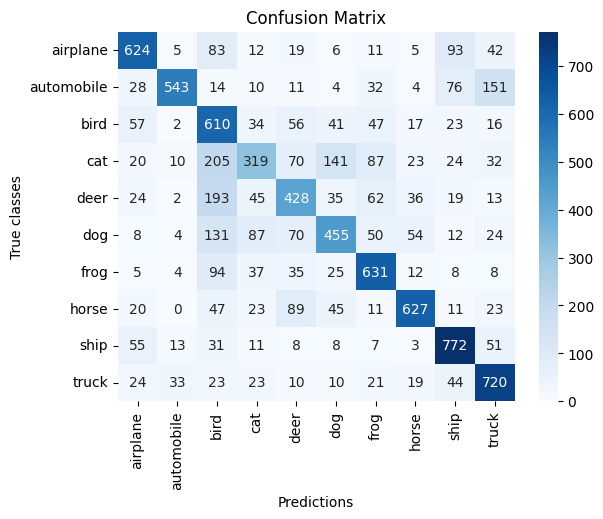

In [24]:
# Definir el modelo
dropout = 0.5
model_mod3 = SimpleCNN_Mod3(num_classes=len(classes), dropout=dropout).to(device)
print("CNN declarada en la variable ''model_mod3'")

# Definir criterio de pérdida: teniendo en cuenta que estamos tratando una tarea de clasificación, usamos Cross Entropy Loss.
criterion = nn.CrossEntropyLoss()

# Definir optimizador
learning_rate = 0.0005
momentum = 0.9
optimizer = optim.SGD(model_mod3.parameters(), lr=learning_rate, momentum=momentum)

# Establecer cantidad de épocas de entrenamiento
num_epochs = 18 # Puedes experimentar aumentando el número de épocas de entrenamiento, especialmente si observas que el modelo no ha convergido con la cantidad actual.

# Entrenar modelo
train_output = train_model(
    model=model_mod3, 
    epochs=num_epochs, 
    train_dataloader=trainloader,
    valid_dataloader=valloader, 
    loss_criterion=criterion, 
    optimizer=optimizer, 
    device=device
    )

train_losses, train_accuracies, valid_losses, valid_accuracies, model_mod3 = train_output
model_mod3 = model_mod3.to(device)

# Evaluar el rendimiento del modelo
test_model(model=model_mod3, test_dataloader=testloader)

### 2. Remover capas completamente conectadas
Exploremos el efecto de remover capas completamente conectadas del modelo de `SimpleCNN`. En el modelo original, teníamos dos capas completamente conectadas, y ahora eliminaremos una capa. Los cambios realizados son los siguientes:

**Capas Completamente Conectadas**
* Se eliminó la capa completamente conectada `fc1`, dejando solo una capa completamente conectada `fc2`.
* La entrada a `fc2` ahora proviene directamente del aplanado de la salida de las capas convolucionales, utilizando lo que era la entrada original de `fc1`.

**Modificación del forward**
La función forward ha sido simplificada para omitir la capa `fc1`, conectando directamente la salida aplanada de las capas convolucionales a `fc2`.

In [32]:
class SimpleCNN_Mod4(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(SimpleCNN_Mod4, self).__init__()
        
        # Definir las capas convolucionales
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 canales de entrada (RGB), 16 filtros, tamaño de kernel 3x3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 canales de entrada, 32 filtros, tamaño de kernel 3x3
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32 canales de entrada, 64 filtros, tamaño de kernel 3x3
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # 64 canales de entrada, 128 filtros, tamaño de kernel 3x3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) # 128 canales de entrada, 256 filtros, tamaño de kernel 3x3
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1) # 256 canales de entrada, 512 filtros, tamaño de kernel 3x3
        
        # Definir las capas de pooling
        self.pool = nn.MaxPool2d(2, 2) # Max pooling con tamaño de ventana 2x2
        
        # Definir la capa completamente conectada
        self.fc2 = nn.Linear(512 * 9, num_classes) # 512 canales de entrada * 9 (después de aplanar), num_classes salidas (clases)
        
        # Añadir dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x))) 
        x = self.pool(F.relu(self.conv6(x))) 
        
        x = x.view(x.size(0), -1) # Aplanar tensor
        
        x = self.dropout(x) # Dropout
        x = self.fc2(x) # Capa completamente conectada (salida)
        
        return x

Ahora entrenamos y evaluamos el modelo modificado siguiendo los mismo pasos utilizamos en nuestra red neuronal convolucional original. 

CNN declarada en la variable ''model_mod4'


  0%|          | 0/1313 [00:00<?, ?it/s]

100%|██████████| 282/282 [00:09<00:00, 29.00it/s]


Epoch [1/18]
Train Loss: 2.2306, Train Accuracy: 16.13%
Validation Loss: 2.0268, Validation Accuracy: 28.06%
** Model checkpoints from epoch 1 with accuracy of 28.06% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:10<00:00, 27.15it/s]


Epoch [2/18]
Train Loss: 1.8584, Train Accuracy: 33.56%
Validation Loss: 1.6862, Validation Accuracy: 39.59%
** Model checkpoints from epoch 2 with accuracy of 39.59% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.75it/s]


Epoch [3/18]
Train Loss: 1.6118, Train Accuracy: 42.09%
Validation Loss: 1.5083, Validation Accuracy: 44.98%
** Model checkpoints from epoch 3 with accuracy of 44.98% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.80it/s]


Epoch [4/18]
Train Loss: 1.4479, Train Accuracy: 48.25%
Validation Loss: 1.3857, Validation Accuracy: 51.14%
** Model checkpoints from epoch 4 with accuracy of 51.14% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.69it/s]


Epoch [5/18]
Train Loss: 1.3242, Train Accuracy: 52.92%
Validation Loss: 1.3172, Validation Accuracy: 54.32%
** Model checkpoints from epoch 5 with accuracy of 54.32% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.99it/s]


Epoch [6/18]
Train Loss: 1.2187, Train Accuracy: 56.81%
Validation Loss: 1.1854, Validation Accuracy: 58.61%
** Model checkpoints from epoch 6 with accuracy of 58.61% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.27it/s]


Epoch [7/18]
Train Loss: 1.1334, Train Accuracy: 60.20%
Validation Loss: 1.0989, Validation Accuracy: 62.46%
** Model checkpoints from epoch 7 with accuracy of 62.46% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.59it/s]


Epoch [8/18]
Train Loss: 1.0622, Train Accuracy: 62.94%
Validation Loss: 1.0500, Validation Accuracy: 64.12%
** Model checkpoints from epoch 8 with accuracy of 64.12% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.38it/s]


Epoch [9/18]
Train Loss: 0.9935, Train Accuracy: 65.52%
Validation Loss: 1.0297, Validation Accuracy: 64.88%
** Model checkpoints from epoch 9 with accuracy of 64.88% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.80it/s]


Epoch [10/18]
Train Loss: 0.9314, Train Accuracy: 67.62%
Validation Loss: 0.9518, Validation Accuracy: 67.57%
** Model checkpoints from epoch 10 with accuracy of 67.57% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.80it/s]


Epoch [11/18]
Train Loss: 0.8801, Train Accuracy: 69.45%
Validation Loss: 0.9457, Validation Accuracy: 67.87%
** Model checkpoints from epoch 11 with accuracy of 67.87% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.43it/s]


Epoch [12/18]
Train Loss: 0.8313, Train Accuracy: 71.45%
Validation Loss: 0.9091, Validation Accuracy: 69.61%
** Model checkpoints from epoch 12 with accuracy of 69.61% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.24it/s]


Epoch [13/18]
Train Loss: 0.7814, Train Accuracy: 73.13%
Validation Loss: 0.8799, Validation Accuracy: 70.21%
** Model checkpoints from epoch 13 with accuracy of 70.21% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.98it/s]


Epoch [14/18]
Train Loss: 0.7352, Train Accuracy: 74.35%
Validation Loss: 0.8537, Validation Accuracy: 71.38%
** Model checkpoints from epoch 14 with accuracy of 71.38% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.37it/s]


Epoch [15/18]
Train Loss: 0.6824, Train Accuracy: 76.25%
Validation Loss: 0.8141, Validation Accuracy: 72.70%
** Model checkpoints from epoch 15 with accuracy of 72.70% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 32.68it/s]


Epoch [16/18]
Train Loss: 0.6421, Train Accuracy: 77.74%
Validation Loss: 0.8432, Validation Accuracy: 71.66%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 35.04it/s]


Epoch [17/18]
Train Loss: 0.6062, Train Accuracy: 79.00%
Validation Loss: 0.7915, Validation Accuracy: 73.64%
** Model checkpoints from epoch 17 with accuracy of 73.64% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:10<00:00, 27.43it/s]


Epoch [18/18]
Train Loss: 0.5672, Train Accuracy: 80.19%
Validation Loss: 0.7713, Validation Accuracy: 73.77%
** Model checkpoints from epoch 18 with accuracy of 73.77% saved in "best_model.pth" **
------------------------------------------------------------------------------------------
Finished Training


100%|██████████| 282/282 [00:10<00:00, 27.56it/s]


Accuracy: 0.74
Precision: 0.74
Recall: 0.74
F1 Score: 0.74
Confusion Matrix:


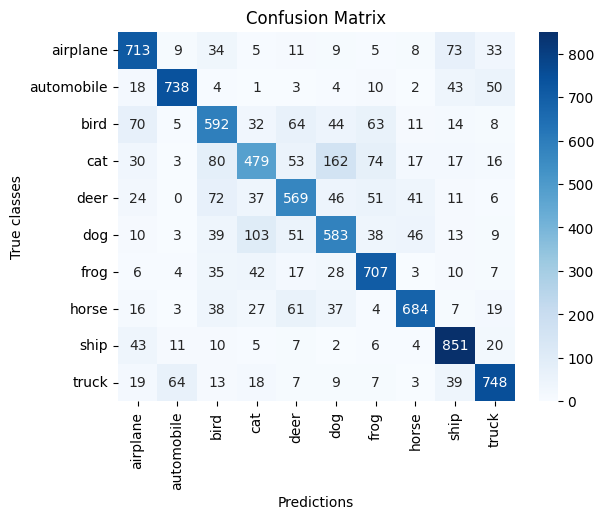

In [33]:
# Definir el modelo
dropout = 0.5
model_mod4 = SimpleCNN_Mod4(num_classes=len(classes), dropout=dropout).to(device)
print("CNN declarada en la variable ''model_mod4'")

# Definir criterio de pérdida: teniendo en cuenta que estamos tratando una tarea de clasificación, usamos Cross Entropy Loss.
criterion = nn.CrossEntropyLoss()
# Definir optimizador
learning_rate = 0.0005
momentum = 0.9
optimizer = optim.SGD(model_mod4.parameters(), lr=learning_rate, momentum=momentum)

# Establecer cantidad de épocas de entrenamiento
num_epochs = 18 # Puedes experimentar aumentando el número de épocas de entrenamiento, especialmente si observas que el modelo no ha convergido con la cantidad actual.

# Entrenar modelo
train_output = train_model(
    model=model_mod4, 
    epochs=num_epochs, 
    train_dataloader=trainloader,
    valid_dataloader=valloader, 
    loss_criterion=criterion, 
    optimizer=optimizer, 
    device=device
    )

train_losses, train_accuracies, valid_losses, valid_accuracies, model_mod4 = train_output
model_mod4 = model_mod4.to(device)

# Evaluar el rendimiento del modelo
test_model(model=model_mod4, test_dataloader=testloader)

### 3. Comparar el tamaño de los modelos usando torchsummary

Comparemos el tamaño de los modelos SimpleCNN y sus variantes modificadas utilizando la librería `torchsummary`. Esta comparación nos permitirá entender cómo los cambios en la arquitectura afectan el número total de parámetros y el uso de memoria en cada modelo.

Los modelos que vamos a comparar son:
* `SimpleCNN`: El modelo original.
* `SimpleCNN_Mod1`: Modelo con capas convolucionales adicionales.
* `SimpleCNN_Mod2`: Modelo con capas convolucionales removidas.
* `SimpleCNN_Mod3`: Modelo con una capa completamente conectada adicional.
* `SimpleCNN_Mod4`: Modelo con una capa completamente conectada removida.

In [21]:
%pip install torch-summary

DEPRECATION: spatialcorr 1.2.0 has a non-standard dependency specifier anndata>=0.7.5scikit-learn>=0.24.2. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of spatialcorr or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [25]:
from torchsummary import summary

num_classes=len(classes)

models = {
    "SimpleCNN": SimpleCNN(num_classes),
    "SimpleCNN_Mod1": SimpleCNN_Mod1(num_classes),
    "SimpleCNN_Mod2": SimpleCNN_Mod2(num_classes),
    "SimpleCNN_Mod3": SimpleCNN_Mod3(num_classes),
    "SimpleCNN_Mod4": SimpleCNN_Mod4(num_classes)
}

# Imprimir el resumen de cada modelo
for name, model in models.items():
    print(f"\n{name} Summary:")
    summary(model)


SimpleCNN Summary:
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            1,180,160
├─MaxPool2d: 1-7                         --
├─Linear: 1-8                            1,179,904
├─Linear: 1-9                            2,570
├─Dropout: 1-10                          --
Total params: 2,755,242
Trainable params: 2,755,242
Non-trainable params: 0

SimpleCNN_Mod1 Summary:
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            1,180,160
├─Conv2d: 1-7      

### 4. Modificar el Dropout

En este ejercicio, vamos a modificar el valor del Dropout en el modelo original SimpleCNN para analizar cómo este cambio afecta las habilidades de la CNN. Dado que el valor de Dropout es uno de los parámetros de nuestro modelo, analizar cómo diferentes tasas de Dropout afectan las habilidades de la CNN es muy sencillo. Simplemente definimos instancias del modelo SimpleCNN con valores de Dropout ajustados. Exploremos el efecto de aumentar el valor de Dropout de `0.5` a `0.7` y de disminuirlo de `0.5` a `0.3`. 

In [35]:
# Definir el número de clases para el ejemplo
num_classes = len(classes)

# Crear instancias del modelo con diferentes valores de Dropout
model_dropout_03 = SimpleCNN(num_classes=num_classes, dropout=0.3).to(device)  # Dropout disminuido
model_dropout_07 = SimpleCNN(num_classes=num_classes, dropout=0.7).to(device)  # Dropout aumentado

Ahora entrenamos y evaluamos los modelos modificados siguiendo los mismo pasos utilizamos en nuestra red neuronal convolucional original. 

100%|██████████| 282/282 [00:09<00:00, 29.10it/s]


Epoch [1/18]
Train Loss: 0.4885, Train Accuracy: 82.43%
Validation Loss: 1.0807, Validation Accuracy: 67.54%
** Model checkpoints from epoch 1 with accuracy of 67.54% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.28it/s]


Epoch [2/18]
Train Loss: 0.4264, Train Accuracy: 84.72%
Validation Loss: 1.1146, Validation Accuracy: 67.64%
** Model checkpoints from epoch 2 with accuracy of 67.64% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 29.71it/s]


Epoch [3/18]
Train Loss: 0.3810, Train Accuracy: 86.49%
Validation Loss: 1.2440, Validation Accuracy: 66.51%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 29.53it/s]


Epoch [4/18]
Train Loss: 0.3262, Train Accuracy: 88.45%
Validation Loss: 1.2382, Validation Accuracy: 67.27%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 30.59it/s]


Epoch [5/18]
Train Loss: 0.2871, Train Accuracy: 89.71%
Validation Loss: 1.3515, Validation Accuracy: 67.49%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 30.20it/s]


Epoch [6/18]
Train Loss: 0.2571, Train Accuracy: 90.97%
Validation Loss: 1.3186, Validation Accuracy: 67.36%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 29.60it/s]


Epoch [7/18]
Train Loss: 0.2285, Train Accuracy: 91.96%
Validation Loss: 1.4687, Validation Accuracy: 67.73%
** Model checkpoints from epoch 7 with accuracy of 67.73% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.71it/s]


Epoch [8/18]
Train Loss: 0.2044, Train Accuracy: 92.93%
Validation Loss: 1.4620, Validation Accuracy: 67.86%
** Model checkpoints from epoch 8 with accuracy of 67.86% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 29.30it/s]


Epoch [9/18]
Train Loss: 0.1812, Train Accuracy: 93.63%
Validation Loss: 1.6225, Validation Accuracy: 67.24%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.30it/s]


Epoch [10/18]
Train Loss: 0.1659, Train Accuracy: 94.14%
Validation Loss: 1.6197, Validation Accuracy: 66.74%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.83it/s]


Epoch [11/18]
Train Loss: 0.1476, Train Accuracy: 94.66%
Validation Loss: 1.5900, Validation Accuracy: 67.94%
** Model checkpoints from epoch 11 with accuracy of 67.94% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.27it/s]


Epoch [12/18]
Train Loss: 0.1383, Train Accuracy: 95.20%
Validation Loss: 1.6383, Validation Accuracy: 68.17%
** Model checkpoints from epoch 12 with accuracy of 68.17% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.68it/s]


Epoch [13/18]
Train Loss: 0.1244, Train Accuracy: 95.62%
Validation Loss: 1.7486, Validation Accuracy: 67.77%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 29.95it/s]


Epoch [14/18]
Train Loss: 0.1122, Train Accuracy: 96.12%
Validation Loss: 1.8386, Validation Accuracy: 67.83%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.93it/s]


Epoch [15/18]
Train Loss: 0.1045, Train Accuracy: 96.46%
Validation Loss: 1.8550, Validation Accuracy: 68.11%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.46it/s]


Epoch [16/18]
Train Loss: 0.1019, Train Accuracy: 96.43%
Validation Loss: 1.7609, Validation Accuracy: 68.49%
** Model checkpoints from epoch 16 with accuracy of 68.49% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.86it/s]


Epoch [17/18]
Train Loss: 0.0963, Train Accuracy: 96.63%
Validation Loss: 1.9327, Validation Accuracy: 68.28%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.25it/s]


Epoch [18/18]
Train Loss: 0.0803, Train Accuracy: 97.33%
Validation Loss: 1.9122, Validation Accuracy: 68.41%
------------------------------------------------------------------------------------------
Finished Training


100%|██████████| 282/282 [00:10<00:00, 28.05it/s]


Accuracy: 0.68
Precision: 0.68
Recall: 0.68
F1 Score: 0.68
Confusion Matrix:


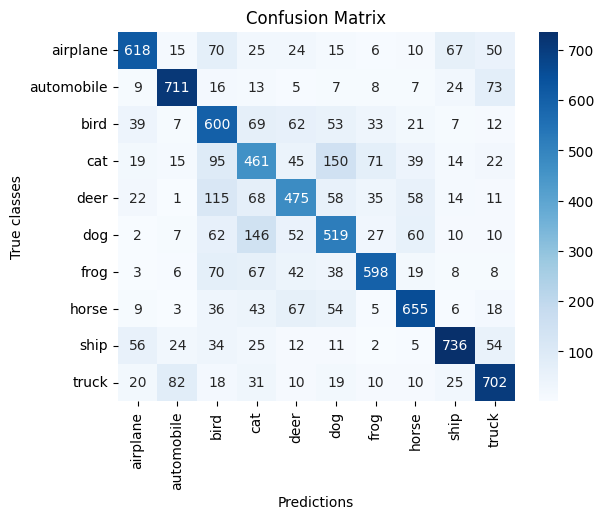

In [34]:
# Definir criterio de pérdida: teniendo en cuenta que estamos tratando una tarea de clasificación, usamos Cross Entropy Loss.
criterion = nn.CrossEntropyLoss()
# Definir optimizador
learning_rate = 0.0005
momentum = 0.9
optimizer = optim.SGD(model_dropout_03.parameters(), lr=learning_rate, momentum=momentum)

# Establecer cantidad de épocas de entrenamiento
num_epochs = 18 # Puedes experimentar aumentando el número de épocas de entrenamiento, especialmente si observas que el modelo no ha convergido con la cantidad actual.

# Entrenar modelo dropout de 0.3
train_output = train_model(
    model=model_dropout_03, 
    epochs=num_epochs, 
    train_dataloader=trainloader,
    valid_dataloader=valloader, 
    loss_criterion=criterion, 
    optimizer=optimizer, 
    device=device
    )

train_losses, train_accuracies, valid_losses, valid_accuracies, model_dropout_03 = train_output
model_dropout_03 = model_dropout_03.to(device)

# Evaluar el rendimiento del modelo dropout de 0.3
test_model(model=model_dropout_03, test_dataloader=testloader)

100%|██████████| 282/282 [00:10<00:00, 27.68it/s]


Epoch [1/18]
Train Loss: 2.3025, Train Accuracy: 10.54%
Validation Loss: 2.3016, Validation Accuracy: 14.37%
** Model checkpoints from epoch 1 with accuracy of 14.37% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.29it/s]


Epoch [2/18]
Train Loss: 2.2985, Train Accuracy: 11.75%
Validation Loss: 2.2879, Validation Accuracy: 13.59%
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.96it/s]


Epoch [3/18]
Train Loss: 2.1548, Train Accuracy: 20.36%
Validation Loss: 1.9860, Validation Accuracy: 29.83%
** Model checkpoints from epoch 3 with accuracy of 29.83% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 29.34it/s]


Epoch [4/18]
Train Loss: 1.9211, Train Accuracy: 30.20%
Validation Loss: 1.7593, Validation Accuracy: 36.47%
** Model checkpoints from epoch 4 with accuracy of 36.47% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 28.46it/s]


Epoch [5/18]
Train Loss: 1.7468, Train Accuracy: 35.95%
Validation Loss: 1.6087, Validation Accuracy: 41.93%
** Model checkpoints from epoch 5 with accuracy of 41.93% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 29.06it/s]


Epoch [6/18]
Train Loss: 1.6255, Train Accuracy: 41.02%
Validation Loss: 1.4973, Validation Accuracy: 44.83%
** Model checkpoints from epoch 6 with accuracy of 44.83% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.33it/s]


Epoch [7/18]
Train Loss: 1.5166, Train Accuracy: 45.18%
Validation Loss: 1.4218, Validation Accuracy: 49.26%
** Model checkpoints from epoch 7 with accuracy of 49.26% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.55it/s]


Epoch [8/18]
Train Loss: 1.4316, Train Accuracy: 48.30%
Validation Loss: 1.3392, Validation Accuracy: 51.02%
** Model checkpoints from epoch 8 with accuracy of 51.02% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.54it/s]


Epoch [9/18]
Train Loss: 1.3561, Train Accuracy: 51.50%
Validation Loss: 1.2833, Validation Accuracy: 54.23%
** Model checkpoints from epoch 9 with accuracy of 54.23% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.02it/s]


Epoch [10/18]
Train Loss: 1.2866, Train Accuracy: 54.12%
Validation Loss: 1.2267, Validation Accuracy: 57.07%
** Model checkpoints from epoch 10 with accuracy of 57.07% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.45it/s]


Epoch [11/18]
Train Loss: 1.2175, Train Accuracy: 57.11%
Validation Loss: 1.1363, Validation Accuracy: 60.21%
** Model checkpoints from epoch 11 with accuracy of 60.21% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.73it/s]


Epoch [12/18]
Train Loss: 1.1530, Train Accuracy: 59.23%
Validation Loss: 1.0777, Validation Accuracy: 62.33%
** Model checkpoints from epoch 12 with accuracy of 62.33% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:07<00:00, 35.32it/s]


Epoch [13/18]
Train Loss: 1.0920, Train Accuracy: 61.51%
Validation Loss: 1.0465, Validation Accuracy: 63.42%
** Model checkpoints from epoch 13 with accuracy of 63.42% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 33.75it/s]


Epoch [14/18]
Train Loss: 1.0384, Train Accuracy: 63.64%
Validation Loss: 1.0187, Validation Accuracy: 64.72%
** Model checkpoints from epoch 14 with accuracy of 64.72% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.45it/s]


Epoch [15/18]
Train Loss: 0.9829, Train Accuracy: 65.49%
Validation Loss: 0.9786, Validation Accuracy: 65.98%
** Model checkpoints from epoch 15 with accuracy of 65.98% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:08<00:00, 34.61it/s]


Epoch [16/18]
Train Loss: 0.9287, Train Accuracy: 67.70%
Validation Loss: 0.9689, Validation Accuracy: 66.52%
** Model checkpoints from epoch 16 with accuracy of 66.52% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 30.35it/s]


Epoch [17/18]
Train Loss: 0.8787, Train Accuracy: 69.19%
Validation Loss: 0.9816, Validation Accuracy: 66.84%
** Model checkpoints from epoch 17 with accuracy of 66.84% saved in "best_model.pth" **
------------------------------------------------------------------------------------------


100%|██████████| 282/282 [00:09<00:00, 30.30it/s]


Epoch [18/18]
Train Loss: 0.8233, Train Accuracy: 70.96%
Validation Loss: 0.9267, Validation Accuracy: 68.00%
** Model checkpoints from epoch 18 with accuracy of 68.00% saved in "best_model.pth" **
------------------------------------------------------------------------------------------
Finished Training


100%|██████████| 282/282 [00:09<00:00, 28.32it/s]


Accuracy: 0.67
Precision: 0.68
Recall: 0.67
F1 Score: 0.66
Confusion Matrix:


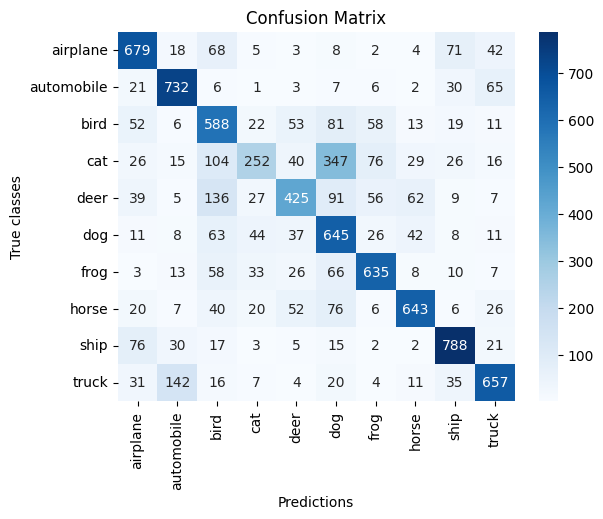

In [36]:
# Definir criterio de pérdida: teniendo en cuenta que estamos tratando una tarea de clasificación, usamos Cross Entropy Loss.
criterion = nn.CrossEntropyLoss()
# Definir optimizador
learning_rate = 0.0005
momentum = 0.9
optimizer = optim.SGD(model_dropout_07.parameters(), lr=learning_rate, momentum=momentum)

# Establecer cantidad de épocas de entrenamiento
num_epochs = 18 # Puedes experimentar aumentando el número de épocas de entrenamiento, especialmente si observas que el modelo no ha convergido con la cantidad actual.

# Entrenar modelo dropout de 0.7
train_output = train_model(
    model=model_dropout_07, 
    epochs=num_epochs, 
    train_dataloader=trainloader,
    valid_dataloader=valloader, 
    loss_criterion=criterion, 
    optimizer=optimizer, 
    device=device
    )

train_losses, train_accuracies, valid_losses, valid_accuracies, model_dropout_07 = train_output
model_dropout_07 = model_dropout_07.to(device)

# Evaluar el rendimiento del modelo dropout de 0.7
test_model(model=model_dropout_07, test_dataloader=testloader)